# Higher-Order Regression

In [3]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [4]:
class HigherOrderRegressor():
    def __init__(self, degree):
        self.degree = degree
        self.X = None
        self.Y = None
        self.B = None
        self.num_features = None

    def fit(self, X, Y):
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        if len(Y.shape) == 1:
            Y = Y.reshape(-1, 1)
        self.num_features=X.shape[1]
        indices=np.random.shuffle(np.arange(X.shape[0]))
        temp_X = X[indices][0]
        temp_Y = Y[indices][0]
        # np.hstack((np.ones((self.X.shape[0], 1)), self.X))
        self.orig_X = np.hstack((np.ones((X.shape[0], 1)), temp_X))
        self.Y = temp_Y
        self.X = self.recursive_generate_powers(0, self.degree, np.ones(X.shape[0])).T
        try:
            self.B = np.matmul(np.linalg.inv(np.matmul(self.X.T, self.X)),
                                np.matmul(self.X.T, self.Y))
        except:
            self.B = np.matmul(np.linalg.pinv(np.matmul(self.X.T, self.X)),
                                np.matmul(self.X.T, self.Y))

    def recursive_generate_powers(self, max_feature_encountered, current_degree, current_product, use_orig=True):
        if current_degree == 0:
            return current_product
        result=[]
        for i in range(max_feature_encountered, self.num_features+1):
            if use_orig:
                result.append(self.recursive_generate_powers(i, current_degree-1,
                                                            current_product*self.orig_X[:,i]))
            else:
                result.append(self.recursive_generate_powers(i, current_degree-1,
                                                            current_product*self.test_X[:,i], False))
        result=np.vstack(result)
        return result
    
    def predict(self, X):
        self.test_X=np.hstack((np.ones((X.shape[0], 1)), X.reshape(-1,1)))
        self.final_testX=self.recursive_generate_powers(0, self.degree, np.ones(X.shape[0]), False).T
        return np.matmul(self.final_testX, self.B)

    def sum_of_squares(self, Y_true, Y_pred):
        return np.sum((Y_true.reshape(-1) - Y_pred.reshape(-1))**2)
    
    def mean_absolute_error(self, Y_true, Y_pred):
        return np.mean(np.abs(Y_true.reshape(-1) - Y_pred.reshape(-1))) 
        
    def r2_score(self, Y_true, Y_pred):
        return 1 - np.sum((Y_true.reshape(-1) - Y_pred.reshape(-1))**2) / np.sum((Y_true.reshape(-1) - np.mean(Y_true.reshape(-1)))**2)
    
    def k_fold_testing(self, k=10):
        width = self.X.shape[0]//k
        average_r2 = 0
        count = 0
        average_ssr = 0
        for i in range(0, self.X.shape[0], width):
            count += 1
            X_train = np.concatenate((self.X[:i], self.X[i+width:]))
            Y_train = np.concatenate((self.Y[:i], self.Y[i+width:]))
            X_test = self.X[i:i+width]
            Y_test = self.Y[i:i+width]
            try:
                B = np.matmul(np.linalg.inv(np.matmul(X_train.T, X_train)), np.matmul(X_train.T, Y_train))
            except:
                B = np.matmul(np.linalg.pinv(np.matmul(X_train.T, X_train)), np.matmul(X_train.T, Y_train))
            predictions = np.matmul(X_test, B)
            average_r2 += self.r2_score(Y_test, predictions)
            average_ssr += self.sum_of_squares(Y_test, predictions)
        # print(self.X.shape)
        try:
            B = np.matmul(np.linalg.inv(np.matmul(self.X.T, self.X)), np.matmul(self.X.T, self.Y))
        except:
            B = np.matmul(np.linalg.pinv(np.matmul(self.X.T, self.X)), np.matmul(self.X.T, self.Y))
        return average_r2/count, self.X.shape[0]*(average_ssr/(count*width)), np.matmul(self.X, B)
    
    def cross_validation(self, params):
        maximum_param=np.max(params)
        self.max_X=self.recursive_generate_powers(0, maximum_param, np.ones(self.X.shape[0])).T
        # print(self.max_X)
        responses = []
        ssrs = []
        factorials=[1]
        for i in range(1, maximum_param+self.num_features+1):
            factorials.append(factorials[-1]*i)
        for param in params:
            self.degree = param
            # print((factorials[param+self.num_features]//factorials[self.num_features])//factorials[param])
            self.X=self.max_X[:,:(factorials[param+self.num_features]//factorials[self.num_features])//factorials[param]]
            response, ssr, plot_values = self.k_fold_testing()
            responses.append(response)
            ssrs.append(ssr)
            fig=plt.figure()
            plt.scatter(self.orig_X[:,1], self.Y)
            indices=np.argsort(self.orig_X[:,1])
            plt.plot(self.orig_X[:,1][indices], plot_values[indices], 'red')
            fig.savefig(f"degree_{param}.png")
        print(responses)
        print(ssrs)
    
    def write_params(self):
        with open("3_weights.pkl", "wb") as f:
            pickle.dump(self.B.reshape((self.degree+1,)), f)


In [5]:
train_data=pd.read_csv('train.csv')

In [6]:
X=train_data['x'].to_numpy()
Y=train_data['y'].to_numpy()

In [7]:
test_data=pd.read_csv('test.csv')

In [8]:
X_test=test_data['x'].to_numpy()

In [9]:
regressor=HigherOrderRegressor(5)
regressor.fit(X, Y)

/tmp/ipykernel_1488400/2909016402.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure()


[0.7037519408495838, 0.7381585151592212, 0.8077314179557049, 0.8832652049729598, 0.8870284799559156, 0.8867798309482324, 0.8860861396437704, 0.8850749418786323, 0.8856143710649113, 0.8845022630963753, 0.8840208668468593, 0.8819087718371167, 0.8798296222492246, 0.8803213039033121, 0.8780225267744411, 0.8815935447915356, 0.8829063867917739, 0.8857626893776909, 0.8822612405615576, 0.880626151471235, 0.8784145701400305, 0.8621610403632618, 0.5541736925722802, -128.39151632381035]
[678747.9382965628, 592366.7833805812, 408863.8765887387, 252157.4167038857, 241342.14391359474, 242087.9009216748, 243876.70040404185, 246526.16388813264, 245291.5983177939, 247463.427041728, 248606.92960476127, 253615.7753618139, 258441.89304283567, 256752.0630479289, 262358.4508368297, 252670.67825324283, 249905.53636346667, 242388.74549357774, 249909.3940510365, 254180.24350399454, 258609.12034010276, 293922.7282364577, 1060706.7383565707, 229533438.35737562]


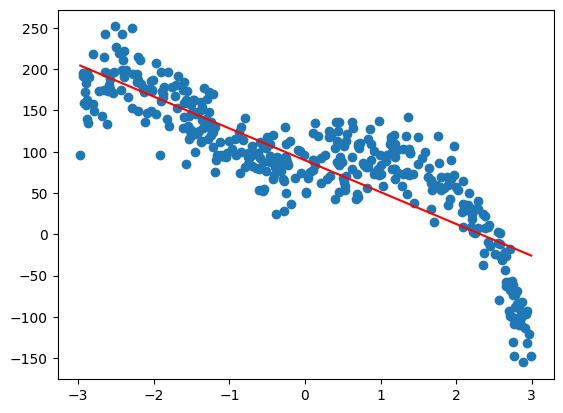

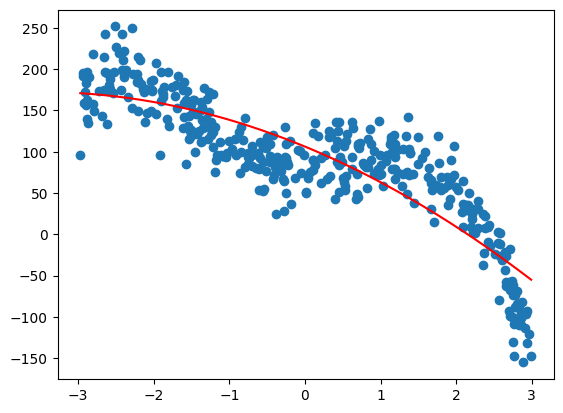

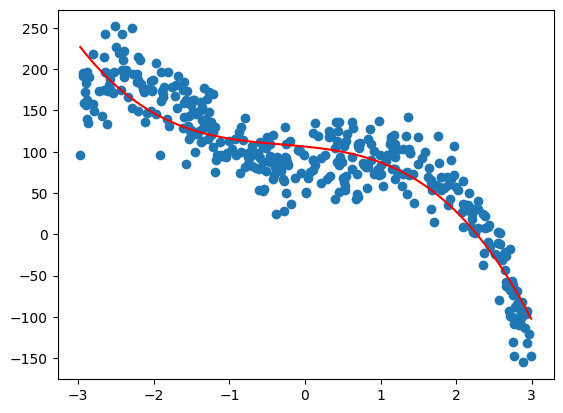

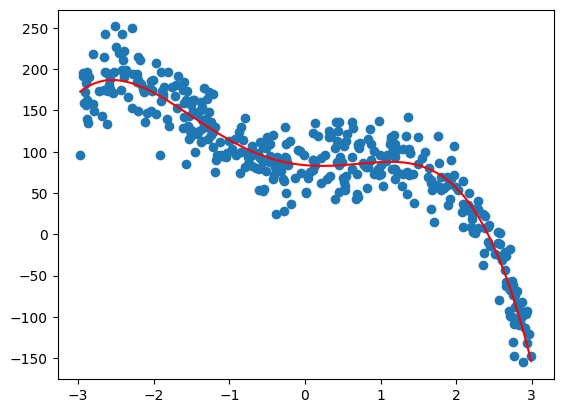

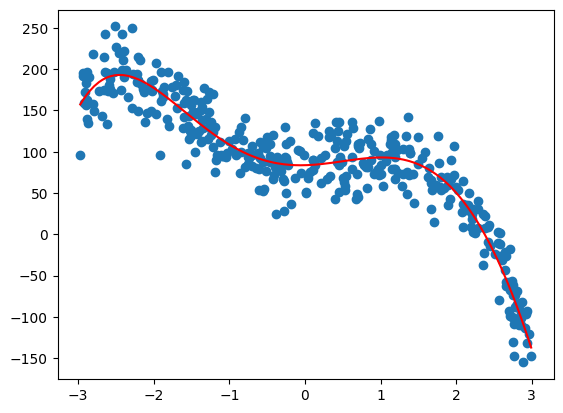

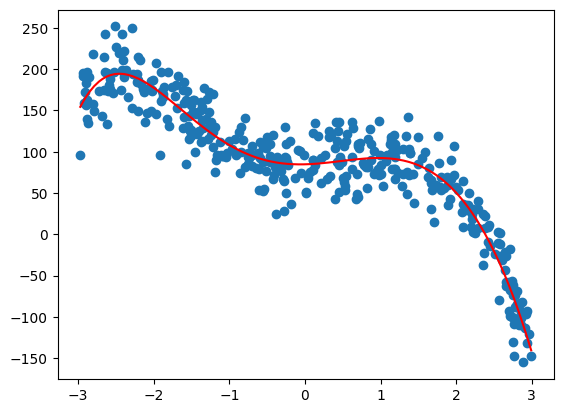

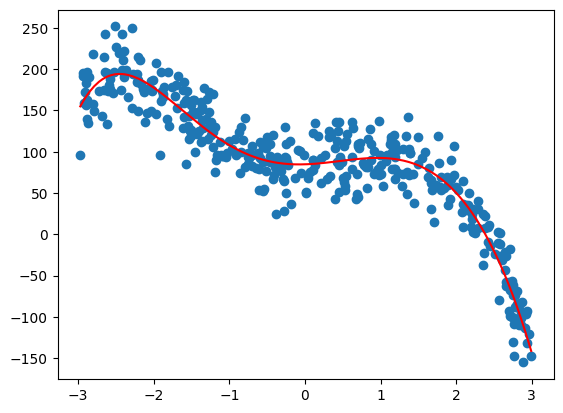

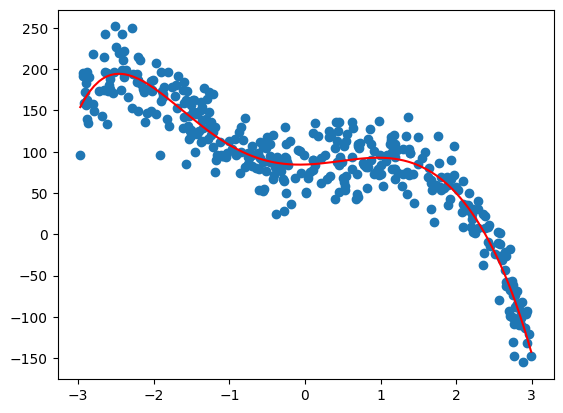

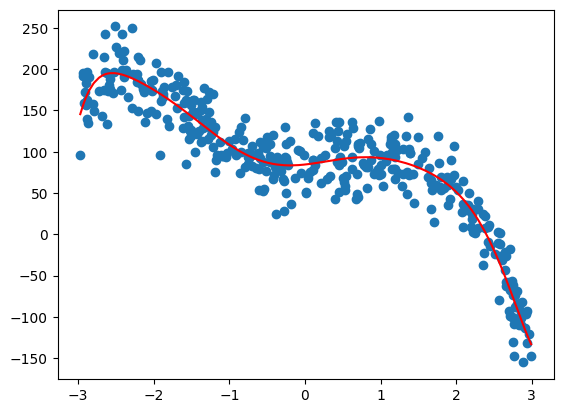

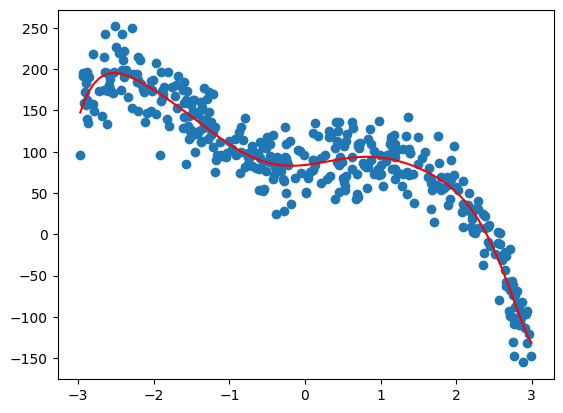

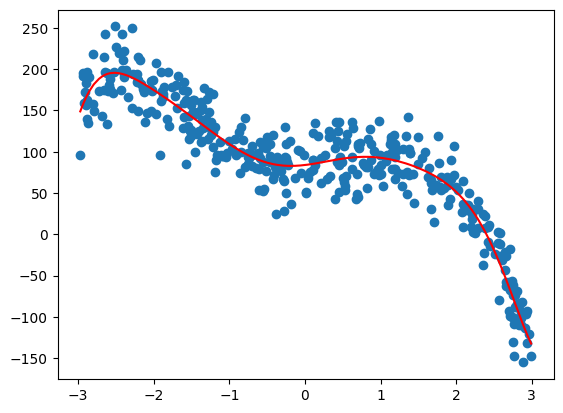

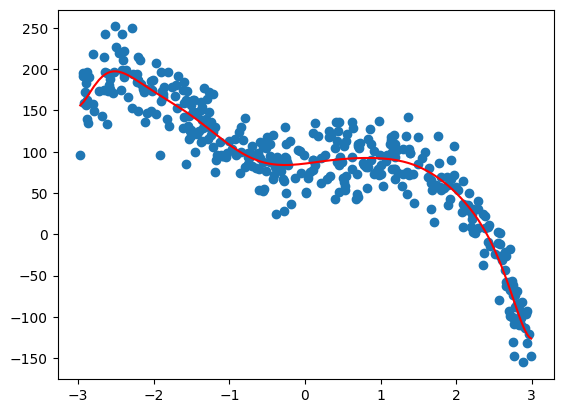

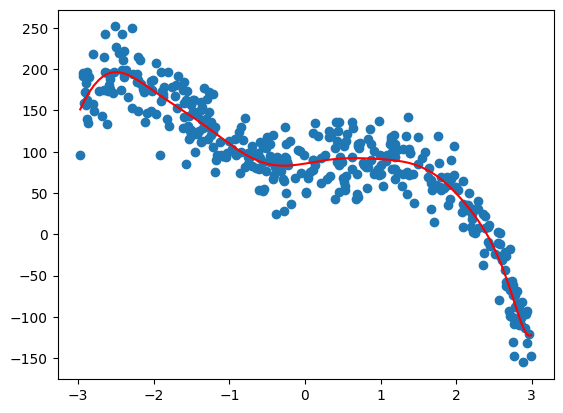

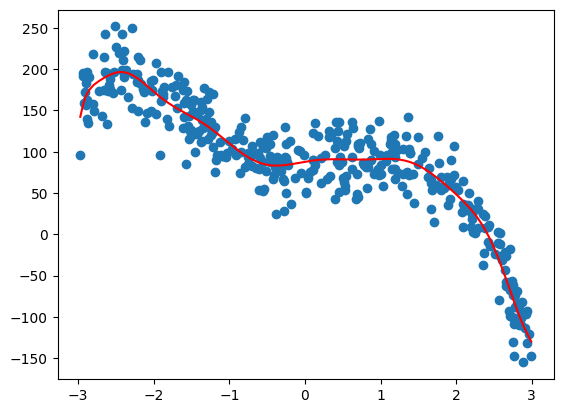

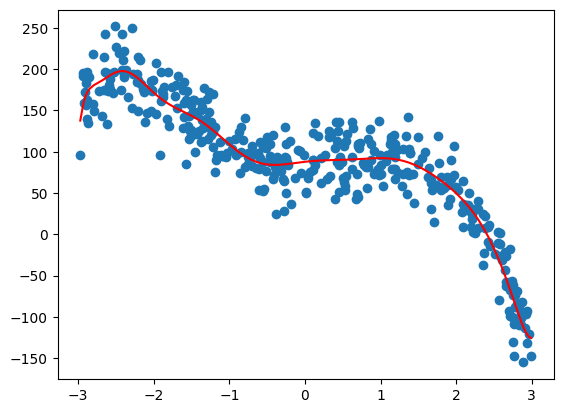

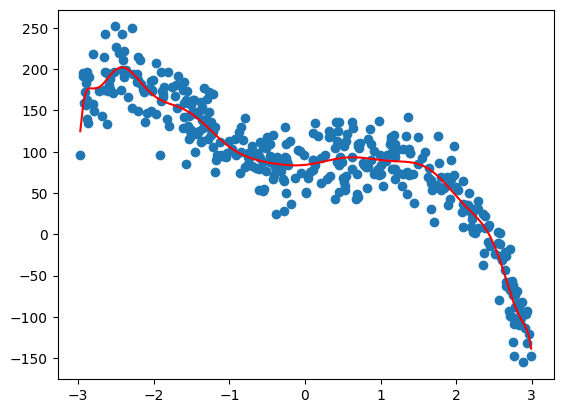

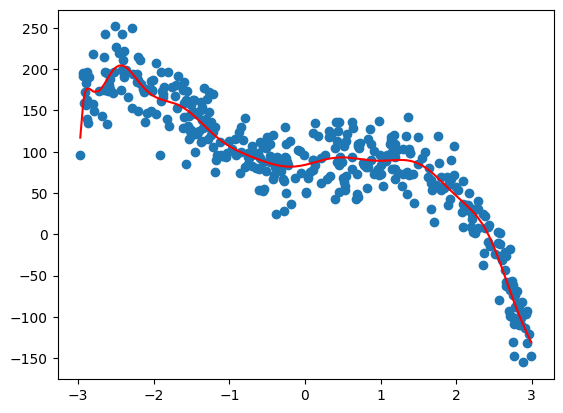

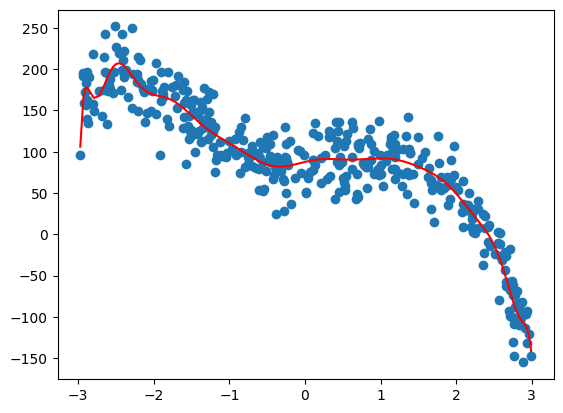

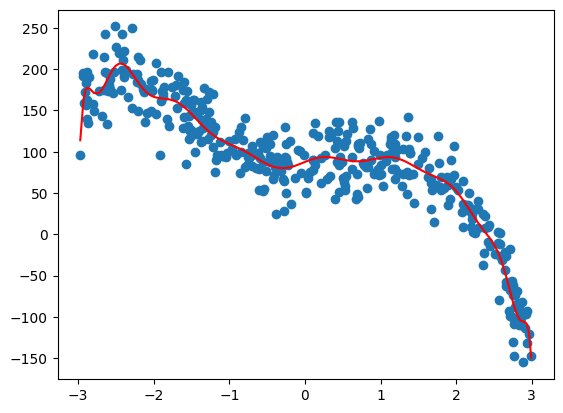

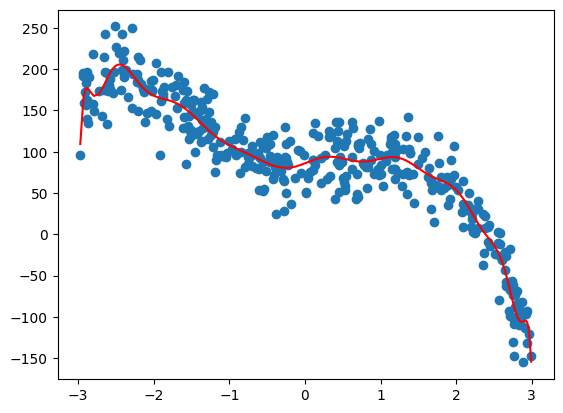

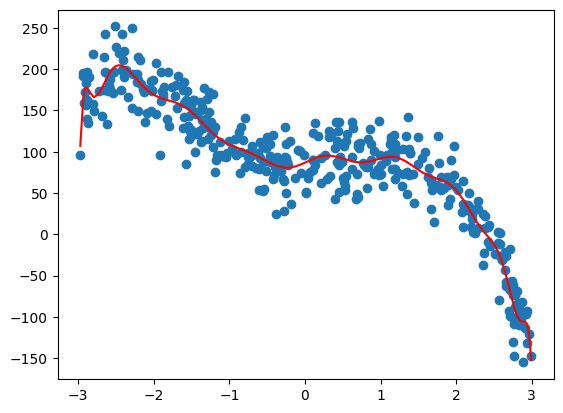

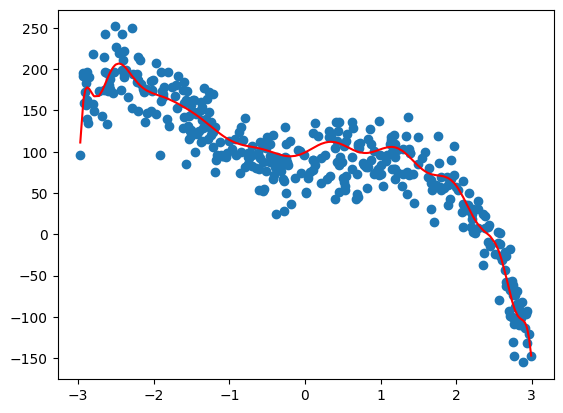

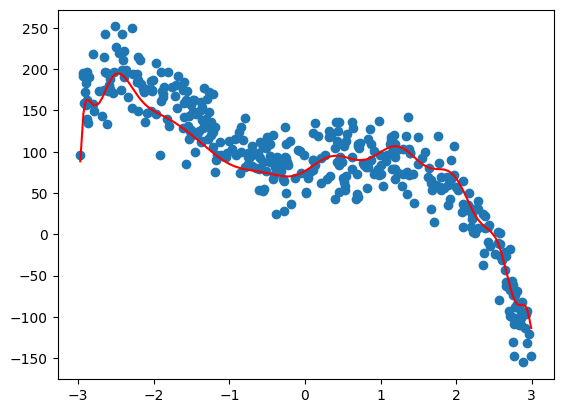

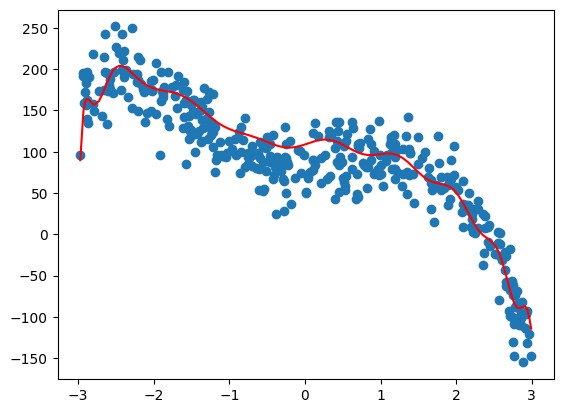

In [10]:
regressor.cross_validation(np.arange(1, 25))

In [11]:
regressor3=HigherOrderRegressor(5)
regressor3.fit(X,Y)

In [12]:
regressor3.write_params()

In [13]:
test_data=pd.read_csv('test.csv')
X_test=test_data['x'].to_numpy()
test_data['y']=regressor3.predict(X_test)

In [14]:
test_data.to_csv('3_predictions.csv', index=False)

In [15]:
import pickle
file=pickle.load(open("3_weights.pkl", "rb"))
print(file.shape)

(6,)


In [16]:
# Testing higher order regression over multiple variables. Here, for lack of other data, I am passing X and Y as the variable columns.
regressor_test=HigherOrderRegressor(5)
regressor_test.fit(np.vstack((X,Y)).T,Y)
regressor_test.B.shape

(21, 1)